In [346]:
# Import packages
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

import zipfile
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [347]:
# importing data aggregated by day
df = pd.read_csv('../data/daily_merged_hydro_climate.csv')
df_climate_last_month = pd.read_csv("../data/climate_data.csv")

In [348]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])
df_climate_last_month['Date Time'] = pd.to_datetime(df_climate_last_month['Date Time'])
print(df.date.max())
print(df_climate_last_month['Date Time'].max())
#df_climate_last_month = df_climate_last_month[df_climate_last_month['Date Time']>df.date.max()].copy().reset_index()
print(df['Snowfall (mm)_sum'].value_counts())
print(df_climate_last_month['Snowfall (mm)'].value_counts())
df.info()

2024-09-23 00:00:00
2024-10-25 00:00:00
Snowfall (mm)_sum
0.000000e+00    58040
4.620000e-07      744
8.160000e-07      695
3.540000e-07      513
4.944941e-03      454
                ...  
2.446000e-05       11
2.088600e-05       11
5.220000e-08       11
1.166000e-06       11
2.480000e-06       11
Name: count, Length: 239, dtype: int64
Snowfall (mm)
0.000000e+00    7567
1.080000e-07      82
3.540000e-07      57
1.230000e-07      46
4.920000e-07      42
                ... 
3.365271e-03       1
3.352590e-03       1
3.342889e-03       1
3.333546e-03       1
5.187684e-02       1
Name: count, Length: 2536, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            136409 non-null  datetime64[ns]
 1   Source                          136409 non-null  obje

In [349]:
aggregated_df_last = df_climate_last_month.resample("1D", on="Date Time").agg({
    'Date Time': "mean",
    'Temperature (°C)': ["mean", "min", "max"],
    'Dewpoint Temperature (°C)': ["mean", "min", "max"],
    'V Wind Component (m/s)': 'mean',
    'U Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum', # Consider 'mean' if this is already a daily total per user
    'Snowfall (mm)': 'sum',        # Consider 'mean' if this is already a daily total per user
    'Snow Cover (%)': 'mean'
}).reset_index(())

# Flatten MultiIndex columns
aggregated_df_last.columns = [f"{col}_{stat}" for col, stat in aggregated_df_last.columns]
aggregated_df_last.columns = aggregated_df_last.columns.str.rstrip('_')

aggregated_df_last = aggregated_df_last.rename(columns={
    "Date Time_mean": "Date Time"
    })
print(aggregated_df_last.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 511 entries, 2023-06-03 to 2024-10-25
Freq: D
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date Time                       511 non-null    datetime64[ns]
 1   Temperature (°C)_mean           511 non-null    float64       
 2   Temperature (°C)_min            511 non-null    float64       
 3   Temperature (°C)_max            511 non-null    float64       
 4   Dewpoint Temperature (°C)_mean  511 non-null    float64       
 5   Dewpoint Temperature (°C)_min   511 non-null    float64       
 6   Dewpoint Temperature (°C)_max   511 non-null    float64       
 7   V Wind Component (m/s)_mean     511 non-null    float64       
 8   U Wind Component (m/s)_mean     511 non-null    float64       
 9   Total Precipitation (mm)_sum    511 non-null    float64       
 10  Snowfall (mm)_sum               511 non-null   

In [350]:
aggregated_df_last.head()

,Date Time,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,Dewpoint Temperature (°C)_mean,Dewpoint Temperature (°C)_min,Dewpoint Temperature (°C)_max,V Wind Component (m/s)_mean,U Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean
Date Time,,,,,,,,,,,,
2023-06-03,2023-06-03 18:00:00,1.860280,-1.513861,7.199731,-3.348664,-4.697501,-2.448126,-0.657726,0.025054,0.004557,0.000000e+00,99.972656
2023-06-04,2023-06-04 11:30:00,3.992740,-3.258566,9.100580,-1.905203,-5.135535,0.460703,-0.505298,-0.180909,0.024096,0.000000e+00,99.972656
2023-06-05,2023-06-05 11:30:00,4.794523,-4.962714,10.031442,-3.781657,-6.197546,-1.211890,-0.498183,-0.145114,0.011580,1.166000e-06,99.972656
2023-06-06,2023-06-06 11:30:00,6.304390,0.213861,11.149500,-4.670615,-6.253607,-1.456351,-0.478623,0.018054,0.008914,5.220000e-08,99.972656
2023-06-07,2023-06-07 11:30:00,7.003922,1.434000,12.092218,-3.965763,-6.164572,-0.884039,-0.516598,0.083701,0.008649,0.000000e+00,99.972656


In [351]:
df.head()

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03,consumer_device_3_data_user_9,0.000576,0.08,0.006786,0.005324,0.000922,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,9,1.344820,0,0,1
1,2023-06-03,consumer_device_3_data_user_4,0.000647,0.09,0.007634,0.005468,0.001066,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,4,1.344820,0,1,0
2,2023-06-03,consumer_device_3_data_user_3,0.000719,0.10,0.008482,0.005468,0.001183,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,3,1.343381,1,0,0
3,2023-06-03,consumer_device_3_data_user_11,0.000647,0.09,0.007634,0.005180,0.001009,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,11,1.344820,0,0,1
4,2023-06-03,consumer_device_3_data_user_5,0.000647,0.09,0.007634,0.005612,0.001094,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,5,1.344820,0,0,1


--- Aggregating Data ---
Aggregated data summary:
        date   kwh_sum  Temperature (°C)_mean  V Wind Component (m/s)_mean   
0 2023-06-03  0.010538               1.860280                    -0.657726  \
1 2023-06-04  0.000000               3.992740                    -0.505298   
2 2023-06-05  0.000000               4.794523                    -0.498183   
3 2023-06-06  0.000000               6.304390                    -0.478623   
4 2023-06-07  0.000000               7.003922                    -0.516598   

   Total Precipitation (mm)_sum  Snowfall (mm)_sum  Snow Cover (%)_mean  
0                      0.004557       0.000000e+00            99.972656  
1                      0.024096       0.000000e+00            99.972656  
2                      0.011580       1.166000e-06            99.972656  
3                      0.008914       5.220000e-08            99.972656  
4                      0.008649       0.000000e+00            99.972656  
Aggregated data shape: (479, 7)

--- 

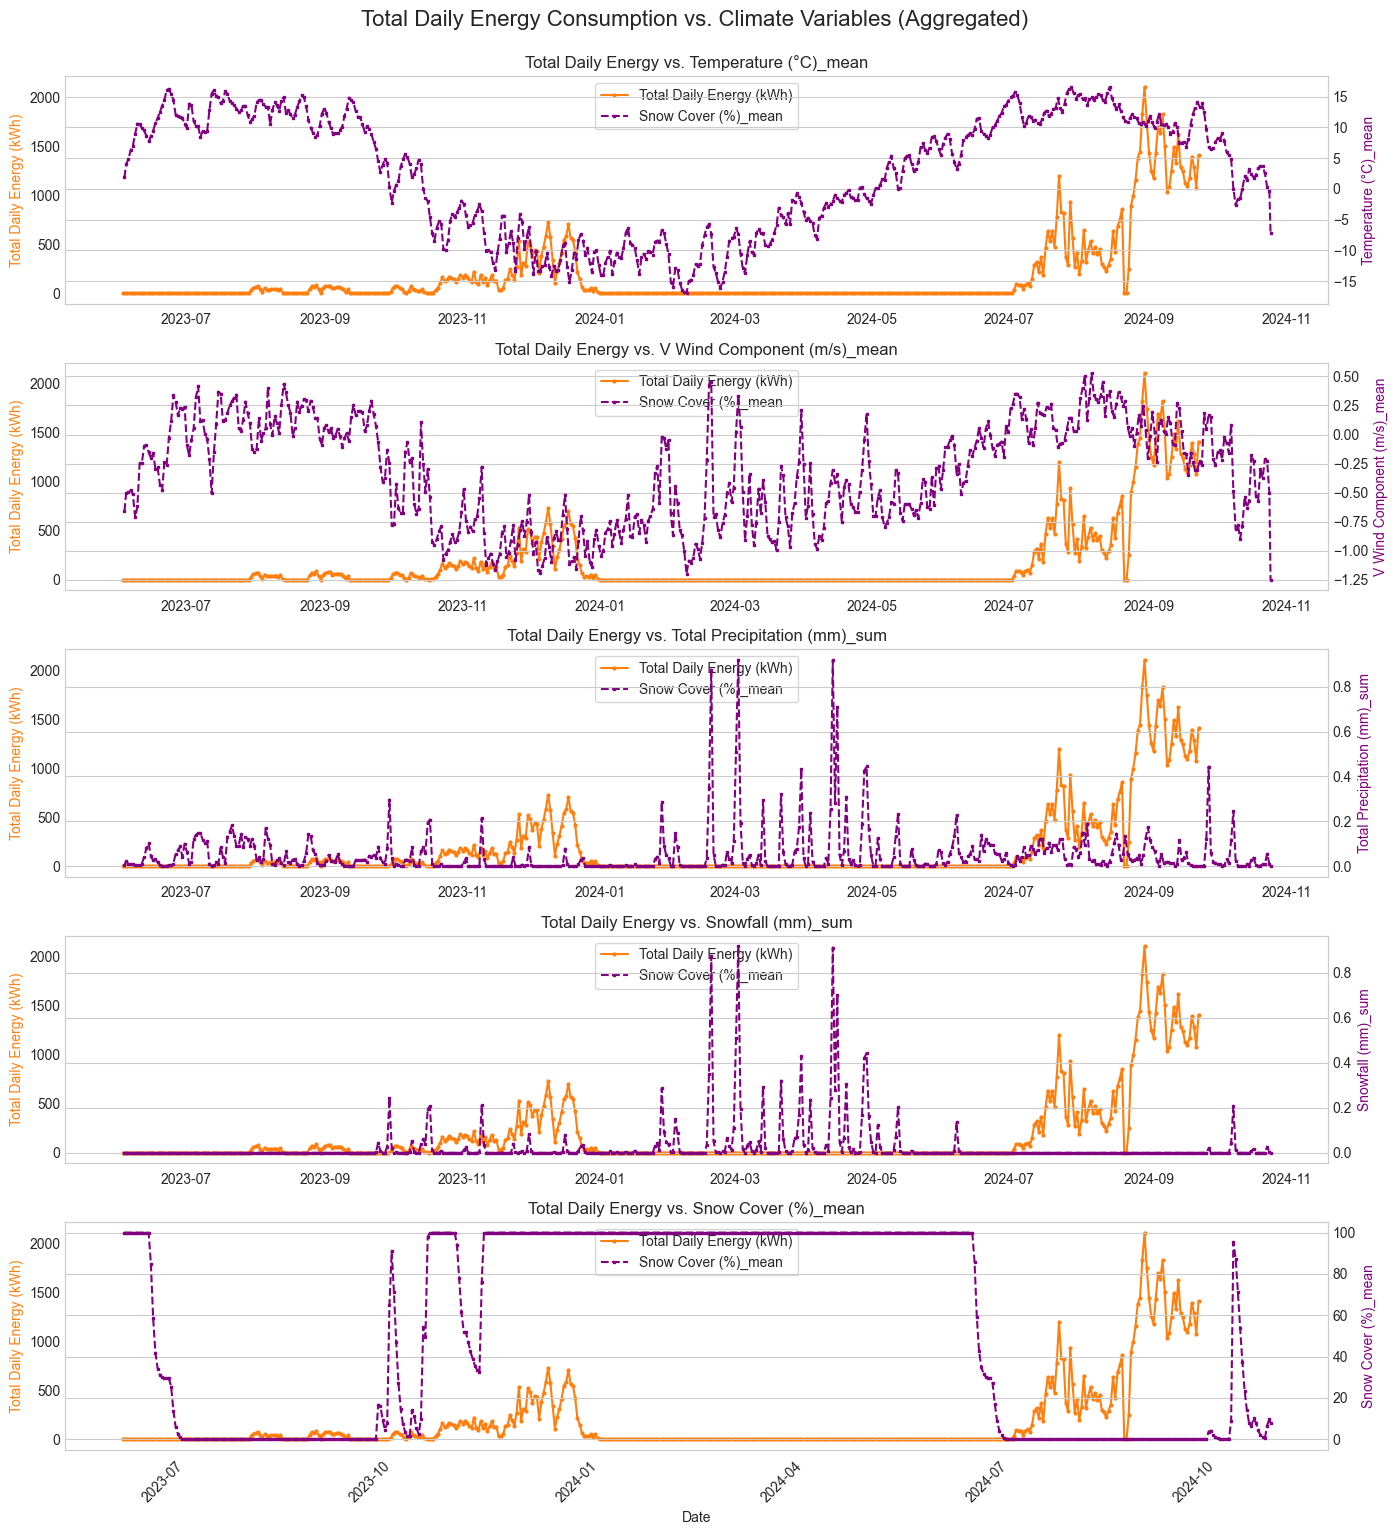

Aggregated dual-axis plot generated successfully.


In [352]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import numpy as np

# --- ASSUMPTION: Your daily data is loaded into a DataFrame called `df`
# df = pd.read_csv('daily_merged_hydro_climate.csv') # Uncomment if needed

# --- 1. Aggregate Data by Date ---
print("--- Aggregating Data ---")
# Group by 'date' and calculate:
# - Sum for kwh_sum (total consumption)
# - Mean for climate variables (average conditions)
aggregated_df = df.groupby('date').agg({
    'kwh_sum': 'sum',                 # Total daily consumption
    'Temperature (°C)_mean': 'mean',
    'V Wind Component (m/s)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'mean', # Consider 'mean' if this is already a daily total per user
    'Snowfall (mm)_sum': 'mean',        # Consider 'mean' if this is already a daily total per user
    'Snow Cover (%)_mean': 'mean'
}).reset_index()

# Sort the aggregated data by date for correct plotting
aggregated_df = aggregated_df.sort_values('date').reset_index(drop=True)

print("Aggregated data summary:")
print(aggregated_df.head())
print(f"Aggregated data shape: {aggregated_df.shape}")

# --- 2. Define Climate Variables to Plot (against Total Energy) ---
# List of climate variables to plot
climate_vars = [
    'Temperature (°C)_mean',
    'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum',
    'Snowfall (mm)_sum',
    'Snow Cover (%)_mean'
]

# --- 3. Create the Multi-Panel Plot ---
n_plots = len(climate_vars)
n_cols = 1
n_rows = n_plots

# Create the figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 3 * n_rows))
# Ensure axes is always a list
if n_plots == 1:
    axes = [axes]

# --- 4. Plot Each Climate Variable vs Total Energy ---
print("\n--- Generating Plots ---")
for i, climate_var in enumerate(climate_vars):
    ax = axes[i]

    if climate_var in aggregated_df.columns and not aggregated_df[climate_var].isna().all():
        # --- Plot 1: Total Daily Energy Consumption (Orange) ---
        line1 = ax.plot(aggregated_df['date'], aggregated_df['kwh_sum'],
                marker='o', linestyle='-', linewidth=1.5, markersize=2,
                color='tab:orange',  # 🔥 Orange for energy
                label='Total Daily Energy (kWh)')

        # --- Plot 2: Climate Variable (Light Blue) ---
        ax2 = ax.twinx()
        line3 = ax2.plot(aggregated_df_last['Date Time'], aggregated_df_last[climate_var],
                marker='s', linestyle='--', linewidth=1.5, markersize=2,
                color='purple')

        # --- Formatting ---
        ax.set_ylabel('Total Daily Energy (kWh)', color='tab:orange')
        ax2.set_ylabel(climate_var, color='purple')

        ax.set_title(f'Total Daily Energy vs. {climate_var}')

        # Remove grid (as requested)
        ax.grid(False)

        # Optional: Hide tick marks (clean look)
        ax.tick_params(axis='y', which='both', length=0)
        ax2.tick_params(axis='y', which='both', length=0)

        # --- Legend ---
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='upper center')

    else:
        ax.text(0.5, 0.5, f'Data not available\n({climate_var})', 
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'Total Daily Energy vs. {climate_var}')


# --- 5. Format Shared X-axis ---
axes[-1].set_xlabel('Date') # Label only the bottom subplot

# Improve date formatting on the shared x-axis using the bottom axis
bottom_ax = axes[-1]
# Determine a suitable date locator based on data range
date_range = aggregated_df['date'].max() - aggregated_df['date'].min()
if date_range.days > 365 * 3:
    bottom_ax.xaxis.set_major_locator(mdates.YearLocator())
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
elif date_range.days > 180:
    bottom_ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
else:
    bottom_ax.xaxis.set_major_locator(mdates.MonthLocator())
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate labels for better readability
plt.setp(bottom_ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- 6. Finalize and Display ---
plt.tight_layout() # Adjust layout to prevent clipping
plt.suptitle('Total Daily Energy Consumption vs. Climate Variables (Aggregated)', fontsize=16, y=1.02)
plt.show()

print("Aggregated dual-axis plot generated successfully.")
